# Main file. Here we will train, run and predict files.

### Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd

### Load data

In [2]:
# Load the data

# Define paths
train_dir = 'data/seg_train'
test_dir = 'data/seg_test'

# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)

# Split training into train and validation
val_batches = int(len(train_dataset) * 0.2)
val_dataset = train_dataset.take(val_batches)
train_dataset = train_dataset.skip(val_batches)

# Data Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Normalization layer
normalization = tf.keras.layers.Rescaling(1./255)

# Apply augmentation only to training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.map(lambda x, y: (normalization(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization(x), y))

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Training batches: 352
Validation batches: 87
Test batches: 94


### Set up models

In [3]:
# Use Transfer Learning with MobileNetV2 (fast and accurate)

# Load pre-trained MobileNetV2 (without top classification layers)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model (we won't train these layers)
base_model.trainable = False

# Build the model
model_cnn = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model_cnn.summary()
print(f"\nTrainable parameters: {sum(p.numel() if hasattr(p, 'numel') else tf.size(p).numpy() for p in model_cnn.trainable_weights):,}")

/var/folders/0m/5c2svgm10xv43m_sr4lhvplc0000gp/T/ipykernel_19172/1065217844.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Trainable parameters: 329,478


In [4]:
# Compile and train (much faster with transfer learning)

# Early stopping - will likely stop around 5-10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Compile the model
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train - only needs ~10 epochs with transfer learning
history = model_cnn.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.7561 - loss: 0.6714 - val_accuracy: 0.8617 - val_loss: 0.3776
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.8068 - loss: 0.5165 - val_accuracy: 0.8660 - val_loss: 0.3658
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.8281 - loss: 0.4829 - val_accuracy: 0.8822 - val_loss: 0.3389
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.8289 - loss: 0.4751 - val_accuracy: 0.8782 - val_loss: 0.3351
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.8251 - loss: 0.4574 - val_accuracy: 0.8790 - val_loss: 0.3370
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - accuracy: 0.8340 - loss: 0.4507 - val_accuracy: 0.8894 - val_loss: 0.3141
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.8385 - loss: 0.4449 - val_accuracy: 0.8703 - val_loss: 0.3430
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.8447 - loss: 0

In [5]:
# Note: This cell should be executed AFTER cell 9 (compile and train)
# Evaluate the model on test set
test_loss, test_acc = model_cnn.evaluate(test_dataset)
print(f'\nTest accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Test loss: {test_loss:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8887 - loss: 0.3045

Test accuracy: 0.8887 (88.87%)
Test loss: 0.3045


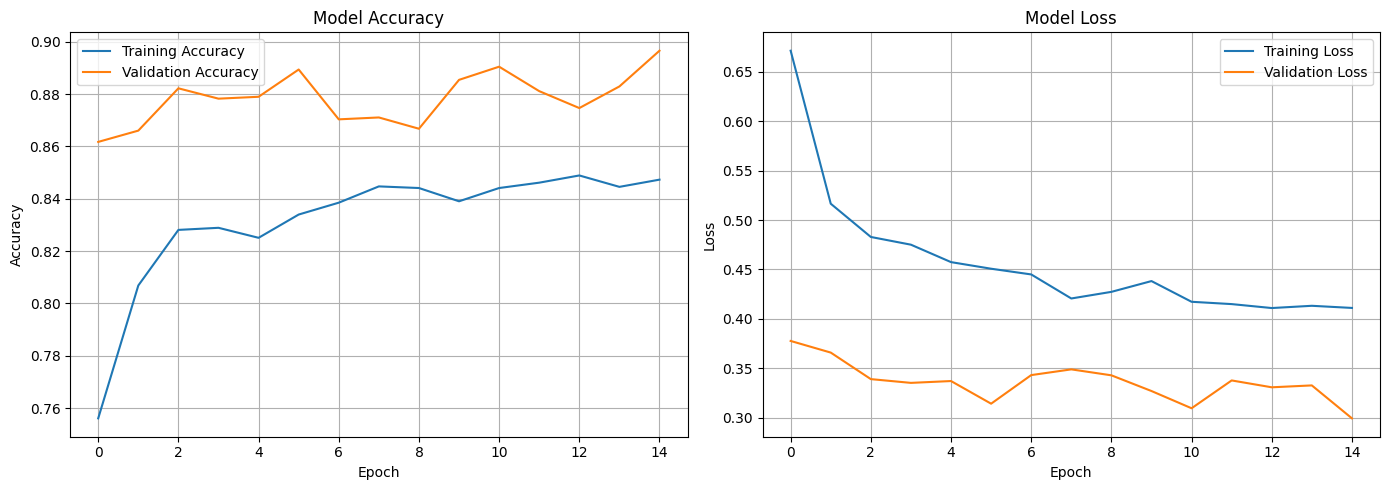

In [7]:
# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Predict on unlabeled data

In [9]:
# Load prediction images (no labels)
pred_dir = 'data/seg_pred'

pred_dataset = tf.keras.utils.image_dataset_from_directory(
    pred_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode=None,  # No labels!
    shuffle=False
)

# Normalize
pred_dataset = pred_dataset.map(lambda x: normalization(x))

# Make predictions
predictions = model_cnn.predict(pred_dataset)

# Get predicted class for each image
predicted_classes = predictions.argmax(axis=1)

# Map to class names
# Get class names from the directory structure
import os
class_names = sorted(os.listdir(train_dir))
# Filter out hidden files and non-directories
class_names = [name for name in class_names if os.path.isdir(os.path.join(train_dir, name)) and not name.startswith('.')]
predicted_labels = [class_names[i] for i in predicted_classes]

# Display some results
print(f"Total images predicted: {len(predicted_labels)}")
print(f"\nPrediction distribution:")
for class_name in class_names:
    count = predicted_labels.count(class_name)
    print(f"  {class_name}: {count} ({count/len(predicted_labels)*100:.1f}%)")

Found 7301 files.
229/229 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step
Total images predicted: 7301

Prediction distribution:
  buildings: 1261 (17.3%)
  forest: 1173 (16.1%)
  glacier: 1334 (18.3%)
  mountain: 1177 (16.1%)
  sea: 1247 (17.1%)
  street: 1109 (15.2%)


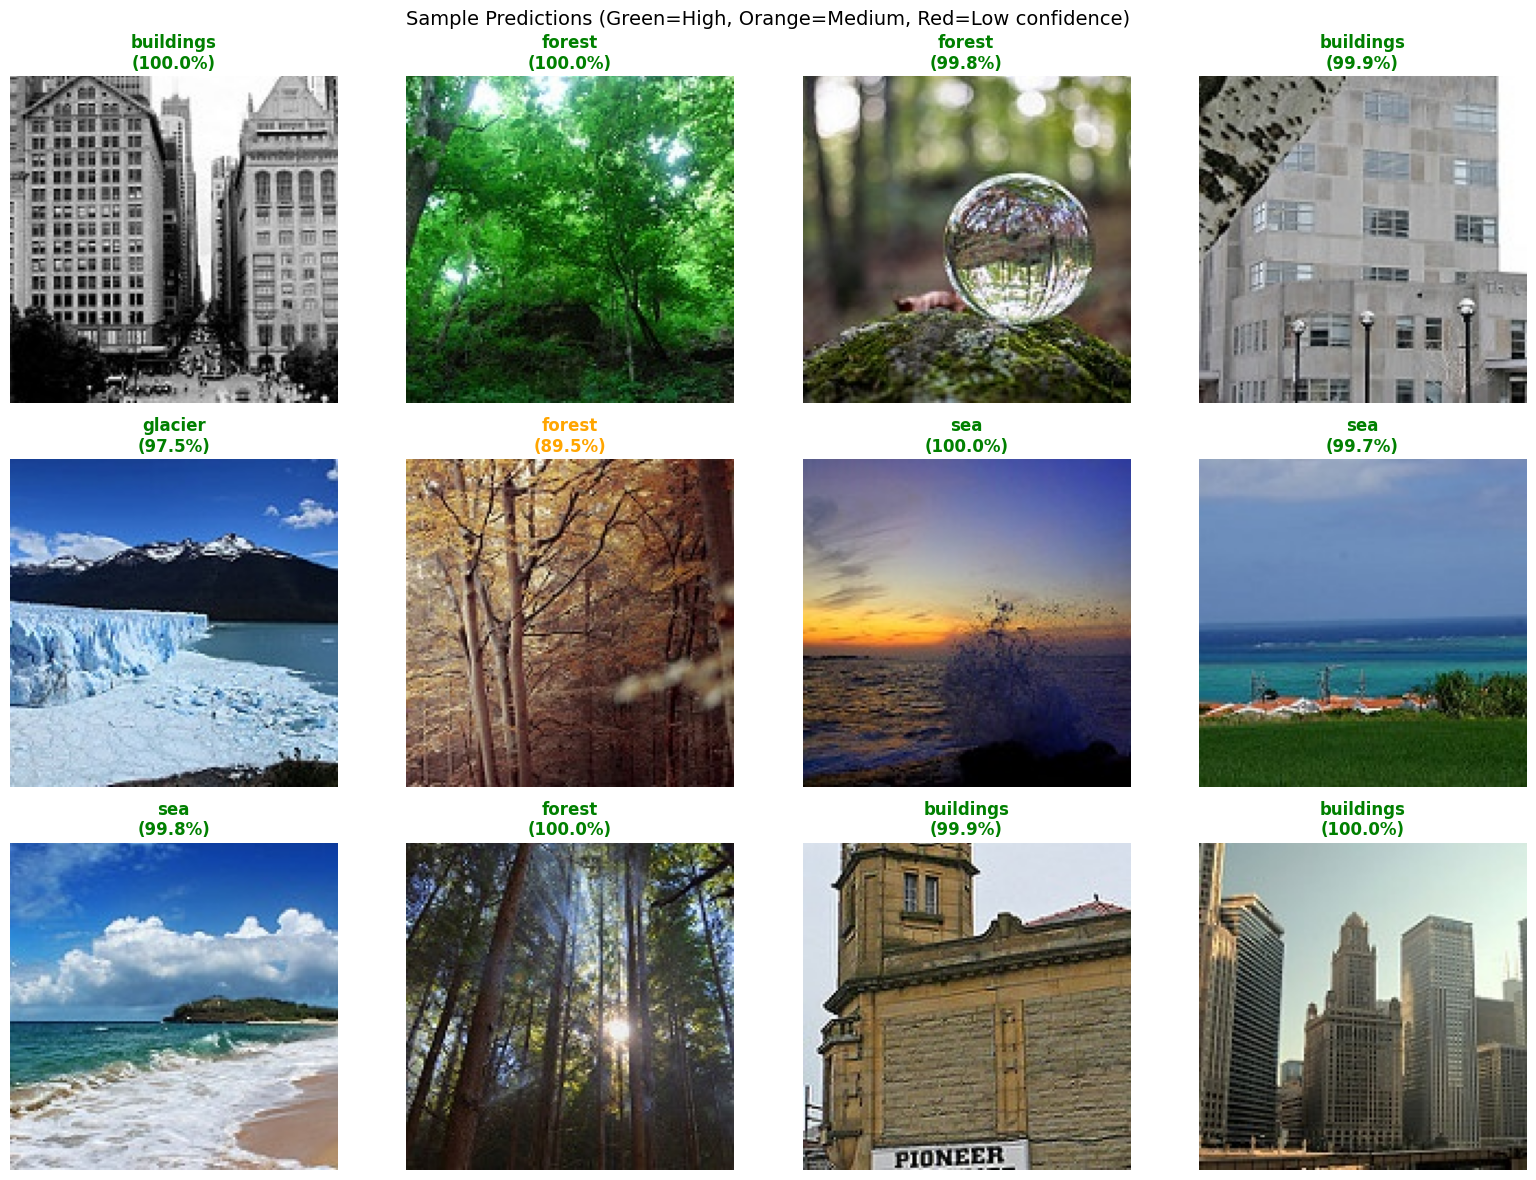


💡 Tip: Look at the images and verify if predictions seem reasonable!
High confidence + correct visual = model is working well


In [11]:
# Visualize sample predictions to manually verify
import matplotlib.pyplot as plt
import os

# Get confidence scores (max probability for each prediction)
confidence_scores = predictions.max(axis=1)

# Get file paths
pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.jpg')])

# Show random sample of predictions
np.random.seed(42)
sample_indices = np.random.choice(len(pred_files), size=12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, ax in zip(sample_indices, axes):
    # Load image
    img_path = os.path.join(pred_dir, pred_files[idx])
    img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
    
    # Get prediction info
    pred_class = predicted_labels[idx]
    conf = confidence_scores[idx]
    
    # Color based on confidence
    color = 'green' if conf >= 0.9 else 'orange' if conf >= 0.7 else 'red'
    
    ax.imshow(img)
    ax.set_title(f"{pred_class}\n({conf:.1%})", fontsize=12, color=color, fontweight='bold')
    ax.axis('off')

plt.suptitle('Sample Predictions (Green=High, Orange=Medium, Red=Low confidence)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n💡 Tip: Look at the images and verify if predictions seem reasonable!")
print("High confidence + correct visual = model is working well")

=== Prediction Confidence Analysis ===

Average confidence: 89.81%
Min confidence: 23.51%
Max confidence: 100.00%

High confidence (≥90%): 5027 (68.9%)
Medium confidence (70-90%): 1264 (17.3%)
Low confidence (<70%): 1010 (13.8%)


=== Prediction Confidence Analysis ===

Average confidence: 89.81%
Min confidence: 23.51%
Max confidence: 100.00%

High confidence (≥90%): 5027 (68.9%)
Medium confidence (70-90%): 1264 (17.3%)
Low confidence (<70%): 1010 (13.8%)


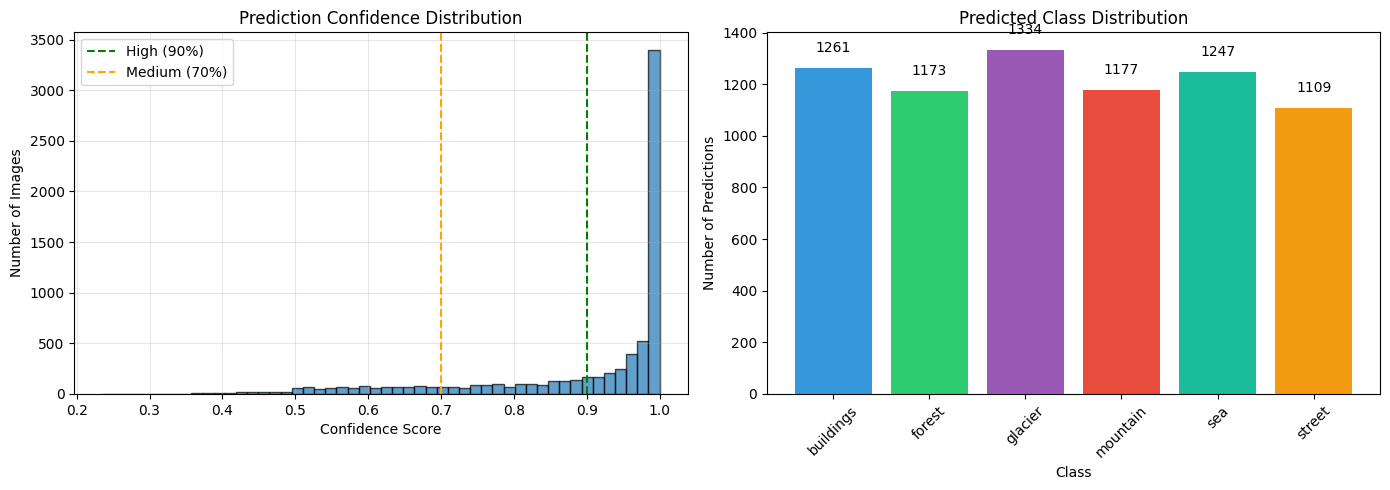

In [12]:
# Evaluate prediction quality (confidence analysis)
import matplotlib.pyplot as plt

# Get confidence scores (max probability for each prediction)
confidence_scores = predictions.max(axis=1)

print("=== Prediction Confidence Analysis ===\n")
print(f"Average confidence: {confidence_scores.mean():.2%}")
print(f"Min confidence: {confidence_scores.min():.2%}")
print(f"Max confidence: {confidence_scores.max():.2%}")

# Count predictions by confidence level
high_conf = (confidence_scores >= 0.9).sum()
medium_conf = ((confidence_scores >= 0.7) & (confidence_scores < 0.9)).sum()
low_conf = (confidence_scores < 0.7).sum()

print(f"\nHigh confidence (≥90%): {high_conf} ({high_conf/len(confidence_scores):.1%})")
print(f"Medium confidence (70-90%): {medium_conf} ({medium_conf/len(confidence_scores):.1%})")
print(f"Low confidence (<70%): {low_conf} ({low_conf/len(confidence_scores):.1%})")

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of confidence scores
axes[0].hist(confidence_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.9, color='green', linestyle='--', label='High (90%)')
axes[0].axvline(x=0.7, color='orange', linestyle='--', label='Medium (70%)')
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart of class distribution
class_counts = [predicted_labels.count(c) for c in class_names]
bars = axes[1].bar(class_names, class_counts, color=['#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#1abc9c', '#f39c12'])
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Predictions')
axes[1].set_title('Predicted Class Distribution')
axes[1].tick_params(axis='x', rotation=45)
for bar, count in zip(bars, class_counts):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()